### Visualising under and over-fitting as parameters scale

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers


import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [2]:
df = pd.read_csv('historic_readings_no_missing_data.csv'
        ).drop(columns=['Unnamed: 0']
        ).sort_values(by='timestamp')

In [3]:
df.sort_values(by='timestamp', inplace=True)

In [4]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])

df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)

In [5]:
# Split the data, 60% in training and 20% in validation, 20% in test, and not randomly selected since this is a time series

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.6))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.8))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
scaled_train = train_data / std

scaled_validation = (validation_data - mean)/std
scaled_test = (test_data - mean)/std


print(f'Mean of training data: {mean},'
      f'\nStandard deviation of training data: {std}')


Mean of training data: temperature    22.981637
dtype: float64,
Standard deviation of training data: temperature    2.30707
dtype: float64


In [6]:
delay = 24
sequence_length = 12

In [7]:
train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

### Defining training run function

This is defined as a function so it can be run easily for different numbers of nodes. 

I also want to keep the training and loss functions for the graphical comparison later, so I store these in a dictionary which is saved as a pickle file. 

In [8]:
def try_lstm_n_nodes(n):

    inputs = keras.Input(shape=(12, 1))

    x = layers.LSTM(n)(inputs)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    history = model.fit(train,
                        epochs=10,
                        validation_data=validation)

    
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)

    print(f'\n========= \
            \nCompleted run for n={n} nodes. \
            \n========= \
            \nFinal val_loss: {val_loss[-1]}' )
    return {'loss': loss, 'val_loss' : val_loss, 'epochs' : epochs}

results = {}

for i in [1,2,4,8,16,32]:
    print(i)
    results[f'{i}'] = try_lstm_n_nodes(i)

with open('lstm_node_experiments.pkl', 'wb') as f:
    pickle.dump(results, f)

1
Epoch 1/10


2023-08-31 14:29:14.436638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-08-31 14:29:14.436933: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9966]
	 [[{{node Placeholder/_8}}]]


9947/9966 [============================>.] - ETA: 0s - loss: 0.1489 - mae: 0.2892

2023-08-31 14:29:31.358545: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-08-31 14:29:31.358841: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3310,1]
	 [[{{node Placeholder/_0}}]]


9966/9966 [==============================] - 19s 2ms/step - loss: 0.1489 - mae: 0.2892 - val_loss: 0.0589 - val_mae: 0.1931
Epoch 2/10
9966/9966 [==============================] - 19s 2ms/step - loss: 0.0985 - mae: 0.2429 - val_loss: 0.0504 - val_mae: 0.1773
Epoch 3/10
9966/9966 [==============================] - 18s 2ms/step - loss: 0.0934 - mae: 0.2362 - val_loss: 0.0478 - val_mae: 0.1720
Epoch 4/10
9966/9966 [==============================] - 18s 2ms/step - loss: 0.0910 - mae: 0.2330 - val_loss: 0.0459 - val_mae: 0.1689
Epoch 5/10
9966/9966 [==============================] - 18s 2ms/step - loss: 0.0897 - mae: 0.2311 - val_loss: 0.0449 - val_mae: 0.1673
Epoch 6/10
9966/9966 [==============================] - 18s 2ms/step - loss: 0.0888 - mae: 0.2296 - val_loss: 0.0447 - val_mae: 0.1663
Epoch 7/10
9966/9966 [==============================] - 18s 2ms/step - loss: 0.0880 - mae: 0.2286 - val_loss: 0.0440 - val_mae: 0.1654
Epoch 8/10
9966/9966 [==============================] - 18s 2ms/st

In [2]:
with open('lstm_node_experiments.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

### Comparing the loss functions depending on the numbers of nodes

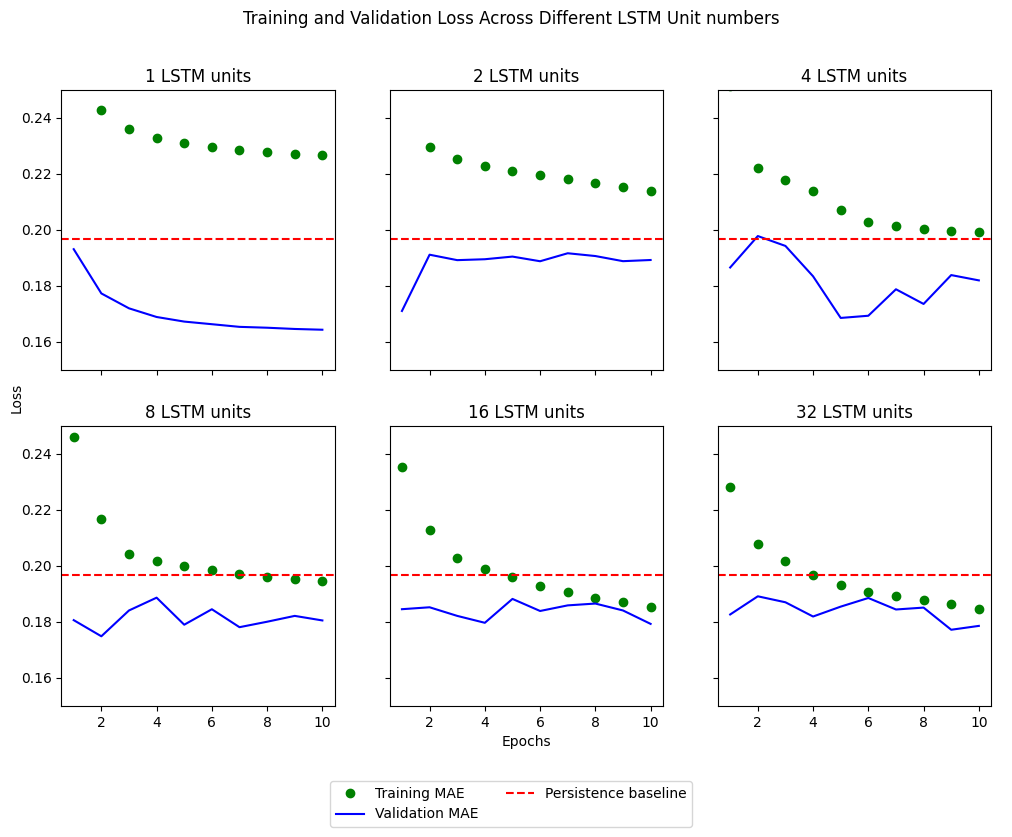

In [3]:
persistence_baseline = 0.1966

# Create the figure and axes
fig, axes = plt.subplots(figsize=(12,8), nrows=2, ncols=3, sharex=True, sharey=True)

# Loop over the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    key = list(loaded_dict.keys())[i]

    epochs = loaded_dict[key]['epochs']
    loss = loaded_dict[key]['loss']
    val_loss = loaded_dict[key]['val_loss']

    ax.plot(epochs, loss, "go", label="Training MAE")
    ax.plot(epochs, val_loss, "b", label="Validation MAE")
    ax.axhline(y=persistence_baseline, color='r', linestyle='--', label='Persistence baseline')
    ax.set_ylim(0.15,0.25)
    ax.set_title(f"{key} LSTM units")
    

# Add a common x-axis label and a common y-axis label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Add the legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

fig.suptitle("Training and Validation Loss Across Different LSTM Unit numbers")

# Display the figure
plt.show()